<a href="https://colab.research.google.com/github/CodeArtificial/Reinforcement-learning_Atari-Pong/blob/main/Reinforcement_learning_Atari_Pong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender ale-py autorom[accept-rom-license]

     |████████████████████████████████| 1.6 MB 4.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=6049948f307f8df3c8db92e2badc4290f6746d1fd81d0068f77376f3f90547aa
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built AutoROM.accept-rom-license


In [ ]:
import gym  
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from collections import deque
import matplotlib.pyplot as plt
import moviepy.editor as mpy

from colabgymrender.recorder import Recorder  

COLLAB = False
DRIVE = ""

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)876544/45929032 bytes (1.9%)3858432/45929032 bytes (8.4%)6316032/45929032 bytes (13.8%)8216576/45929032 bytes (17.9%)10649600/45929032 bytes (23.2%)13238272/45929032 bytes (28.8%)16187392/45929032 bytes (35.2%)19185664/45929032 bytes (41.8%)20774912/45929032 bytes (45.2%)23379968/45929032 bytes (50.9%)25526272/45929032 bytes (55.6%)28164096/45929032 bytes (61.3%)30908

In [ ]:
pong_inputdim = (1, 80, 80)
def run_episode(env, policy, max_steps=2000, isAtari=False, render=(not COLLAB)):
    observation = env.reset()
    if (isAtari):
        curx = prepro(observation)
    else:
        curx = observation
    prevx = None
    observations = []
    rewards = []
    rawframes = []
    log_probs = []

    for _ in range(max_steps):
        if render:
            env.render()
        observation = torch.tensor(observation) 
        if isAtari:
            x = curx - prevx if prevx is not None else np.zeros(pong_inputdim)
            x = torch.tensor(x)
            action, log_p = policy.select_action(x)
        else:
            action, log_p = policy.select_action(observation)
        
        observation, reward, done, info = env.step(action)
        prevx = curx
        if (isAtari):
            curx = prepro(observation)
        observations.append(curx)
        rewards.append(reward)
        rawframes.append(observation)  
        log_probs.append(log_p)
        if done:
            break

    return rewards, log_probs, observations, rawframes

In [ ]:
def discount_rewards(r, gamma=0.99, isAtari=False):
    discounted_r = np.zeros_like(r)

    running_add = 0
    eps = np.finfo(np.float32).eps.item()
    for t in reversed(range(0, len(r))):
        if r[t] != 0 and isAtari:
            running_add = 0
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add

    discounted_r -= np.mean(discounted_r)
    discounted_r /= np.std(discounted_r) + eps

    if (not isAtari):
        discounted_r = torch.tensor([np.sum(r[i:]*(gamma**np.array(range(i, len(r))))) for i in range(len(r))])]
        
    return discounted_r

In [ ]:
class LinearPolicy(nn.Module):

    def __init__(self, num_states, num_actions):
        super(LinearPolicy, self).__init__()
        self.lin1 = nn.Linear(num_states, 400)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(400, num_actions)
        self.num_inputs = num_states

    def forward(self, state):
        out = self.lin1(state)
        out = self.relu(out)
        out = self.lin2(out)
        return F.softmax(out)

    def select_action(self, state):
        state = state.float().unsqueeze(0)
        probs = self(state)
        m = Categorical(probs)
        action = m.sample()
        log_p = m.log_prob(action)
        return action.item(), log_p

In [ ]:
def train(env, policy, state, isAtari=False, checkpoint=None, render=(not COLLAB), saveanimations=False):
    print_interval = 100
    if isAtari:
        print_interval = 10

    if checkpoint != None:
        policy = torch.load(DRIVE+"checkpoints/"+checkpoint)
        print("Resumed checkpoint {}".format(checkpoint))
    else:
        checkpoint = DRIVE+"checkpoints/" + env.unwrapped.spec.id + "policy_gradient.pt"

    if isAtari:
        print("RMSProp Optimizer")
        optimizer = torch.optim.RMSprop(policy.parameters(), lr=1e-4)
    else:
        print("Adam Optimizer")
        optimizer = torch.optim.Adam(policy.parameters(), lr=0.001)
    episode = 0
    episode_rewards = []
    while True:
        rewards, log_probs, observations, rawframes = run_episode(env, policy, isAtari=isAtari, render=render)
        episode_rewards.append(np.sum(rewards))

        if episode % print_interval == 0:
            print("Total reward for episode {}: {}".format(episode, np.sum(rewards)))
        loss = []
        D_rewards = discount_rewards(rewards, gamma=0.99, isAtari=isAtari)
        for time in range(len(D_rewards)):
          loss.append(-1 * D_rewards[time] * log_probs[time])
        loss = sum(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        episode += 1
        if episode % 50 == 0:
            torch.save(policy, checkpoint)
        if saveanimations and episode % 50 == 0:
            saveanimations(rawframes, "{}_episode{}.mp4".format(DRIVE+"video/pong", episode))
        if not isAtari and episode % 1000 == 0:
            break
    return episode_rewards

In [ ]:
env = gym.make("CartPole-v0")
policy = LinearPolicy(env.observation_space.shape[0], env.action_space.n)

for n in range(10):
    run_episode(env, policy, isAtari=False, render=(not COLLAB))


env.close()


In [ ]:
env = gym.make("CartPole-v0")

episode_rewards = train(env, policy, state=None, checkpoint=None, render=(not COLLAB))



Adam Optimizer
Total reward for episode 0: 15.0
Total reward for episode 100: 48.0
Total reward for episode 200: 65.0
Total reward for episode 300: 200.0
Total reward for episode 400: 135.0
Total reward for episode 500: 200.0
Total reward for episode 600: 146.0
Total reward for episode 700: 117.0
Total reward for episode 800: 110.0
Total reward for episode 900: 42.0


In [ ]:
env = gym.make("CartPole-v0")
policy = LinearPolicy(env.observation_space.shape[0], env.action_space.n)

for n in range(10):
    run_episode(env, policy, isAtari=False, render=(not COLLAB))


env.close()


In [ ]:
env = gym.make("CartPole-v0")

episode_rewards = train(env, policy, state=None, checkpoint=None, render=(not COLLAB))



Adam Optimizer
Total reward for episode 0: 44.0
Total reward for episode 100: 42.0
Total reward for episode 200: 183.0
Total reward for episode 300: 188.0
Total reward for episode 400: 148.0
Total reward for episode 500: 200.0
Total reward for episode 600: 200.0
Total reward for episode 700: 200.0
Total reward for episode 800: 200.0
Total reward for episode 900: 179.0


In [ ]:
for n in range(10):
    run_episode(env, policy, isAtari=False, render=(not COLLAB))
env.close()


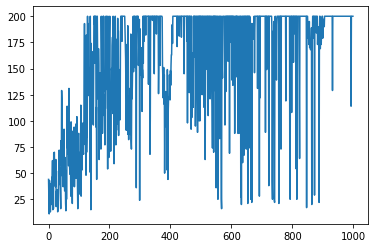

In [ ]:
plt.plot(episode_rewards)

In [ ]:
env = gym.make("Pong-v0")

if COLLAB:
    env = Recorder(env, DRIVE+"/video")

obs = env.reset()
terminal = False
while not terminal:
    action = env.action_space.sample()
    obs, r, terminal, info = env.step(action)

if COLLAB:
    env.play()

env.close()

In [ ]:
env = gym.make("Pong-v0")
pong_inputdim = (1, 80, 80)

def prepro(image):
    image = image[35:195]
    image = image[::2, ::2, 0]
    image[image == 144] = 0
    image[image == 109] = 0
    image[image != 0] = 1
    return np.reshape(image, pong_inputdim)

(210, 160, 3)


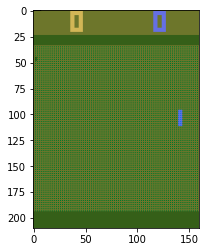

(1, 80, 80)


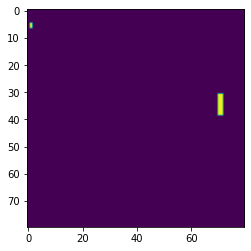

In [ ]:
raw_image = env.reset()
preprocessed_image = prepro(raw_image)

print(raw_image.shape)
plt.imshow(raw_image)
plt.show()

print(preprocessed_image.shape)
plt.imshow(preprocessed_image.squeeze(0))

In [ ]:
class CNNPolicy(nn.Module):
    def __init__(self):
        super(CNNPolicy, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.lin1 = nn.Linear(1568, 6)
        
    def forward(self, x):
        x = F.relu(self.bn1((self.conv1(x))))
        x = F.relu(self.bn2((self.conv2(x))))
        x = F.relu(self.bn3((self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.lin1(x)
        x = F.softmax(x, dim=1)
        return x
    
    def select_action(self, state):
        state = state.float().unsqueeze(0)
        probs = self(state)
        m = Categorical(probs)
        action = m.sample()
        log_p = m.log_prob(action)
        return action.item(), log_p
    

def saveanimation(rawframes, filename):
    clip = mpy.ImageSequenceClip(rawframes, fps=60)
    clip.write_videofile(filename)

In [ ]:
env = gym.make("Pong-v0")

if COLLAB:
    env = Recorder(env, DRIVE+"/video")

policy = CNNPolicy()
run_episode(env, policy, isAtari=True, render=(not COLLAB))

if COLLAB:
    env.play()

env.close()

In [ ]:
env = gym.make("Pong-v0")

policy = CNNPolicy()

episode_rewards = train(env, policy, state=None, isAtari=True, checkpoint=None, render=(not COLLAB), saveanimations=False)

RMSProp Optimizer
Total reward for episode 0: -20.0
Total reward for episode 10: -21.0
Total reward for episode 20: -20.0
Total reward for episode 30: -19.0
Total reward for episode 40: -20.0
Total reward for episode 50: -21.0
Total reward for episode 60: -20.0
Total reward for episode 70: -21.0
Total reward for episode 80: -20.0
Total reward for episode 90: -19.0


KeyboardInterrupt: ignored

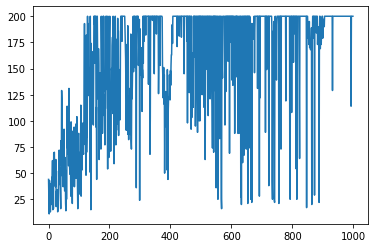

In [ ]:
plt.plot(episode_rewards)

In [ ]:
if COLLAB:
    env = Recorder(env, DRIVE+"/video")

run_episode(env, policy, isAtari=True, render=(not COLLAB))

if COLLAB:
    env.play()
    
env.close()

In [ ]:
def Model3():

    #
    def image_process(image, processed_image, dimension):
        image = image[35:195]
        image = image[::2, ::2, :]
        image = image[:, :, 0]
        image[image == 144] = 0
        image[image == 109] = 0
        image[image != 0] = 1

        image = image.astype(np.float).ravel()

        if processed_image is not None:
            input_observation = image - processed_image
        else:
            input_observation = np.zeros(dimension)

        processed_image = image
        return input_observation, processed_image

    #
    def discount_rewards(gradient_log, rewards, gamma):
        discounted_r = np.zeros_like(rewards)
        running_add = 0
        for time in reversed(range(0, len(rewards))):
            if rewards[time] != 0:
                running_add = 0
            running_add = running_add * gamma + rewards[time]
            discounted_r[time] = running_add

        discounted_r -= np.mean(discounted_r)
        discounted_r /= np.std(discounted_r)
        return gradient_log * discounted_r

    #
    def update_weight(weights, expectation, layer_dict, DECAY, LR):
        for layer in weights.keys():
            expectation[layer] = DECAY * expectation[layer] + (1 - DECAY) * layer_dict[layer]**2
            weights[layer] += (LR * layer_dict[layer])/(np.sqrt(expectation[layer] + 1e-5))
            layer_dict[layer] = np.zeros_like(weights[layer])

    #
    def compute_gradient(gradient, hidden_layer, observation, weights):
        dw2 = np.dot(hidden_layer.T, gradient).ravel()
        d = np.outer(gradient, weights['2'])
        d[d < 0] = 0
        dw1 = np.dot(d.T, observation)
        return { '1': dw1, '2': dw2 }

    #
    def neural_net(observation, weights):
        hl_val = np.dot(weights['1'], observation)
        hl_val[hl_val < 0] = 0
        ol_val = np.dot(hl_val, weights['2'])
        ol_val = 1.0 / (1.0 + np.exp(-ol_val))
        return hl_val, ol_val

    env = gym.make("Pong-v0")
    observation = env.reset()

    # Initial hyperparameters
    EPISODE = 0
    BATCH = 10
    GAMMA = 0.99
    DECAY = 0.99
    HIDDEN_LAYER_NEURON = 200
    INPUT = 80 * 80
    LR = 1e-4
    REWARD = 0
    RUNNING_REWARD = None
    PREV_OBSERVATION = None


    # calculation variable
    expectation, layer_dict = {}, {}
    hidden_layer, observations, gradient, ep_rewards = [], [], [], []


    # initalize the weights for players
    weights = {
        '1': np.random.randn(HIDDEN_LAYER_NEURON, INPUT) / np.sqrt(INPUT),
        '2': np.random.randn(HIDDEN_LAYER_NEURON) / np.sqrt(HIDDEN_LAYER_NEURON)
    }

    #
    for layer in weights.keys():
        expectation[layer] = np.zeros_like(weights[layer])
        layer_dict[layer] = np.zeros_like(weights[layer])


    while True:
        p_observations, PREV_OBSERVATION = image_process(observation, PREV_OBSERVATION, INPUT)
        observations.append(p_observations)

        hidden_layer_values, probability = neural_net(p_observations, weights)
        hidden_layer.append(hidden_layer_values)

        if np.random.uniform() < probability:
            move = 2
        else:
            move = 3

        observation, reward, sig, info = env.step(move)
        REWARD += reward
        ep_rewards.append(reward)

        if move == 3:
          label = 0
        else:
          label = 1

        gradient.append(label - probability)


        if sig:
            EPISODE += 1

            hidden_layer = np.vstack(hidden_layer)
            observations = np.vstack(observations)
            gradient = np.vstack(gradient)
            ep_rewards = np.vstack(ep_rewards)
            
            g_discounted = discount_rewards(gradient, ep_rewards, GAMMA)

            gradient = compute_gradient(g_discounted, hidden_layer, observations, weights)

            for layer_name in gradient:
                layer_dict[layer_name] += gradient[layer_name]

            if EPISODE % BATCH == 0:
                update_weight(weights, expectation, layer_dict, DECAY, LR)

            hidden_layer, observations, gradient, ep_rewards = [], [], [], []
            observation = env.reset()

            if RUNNING_REWARD is None:
              RUNNING_REWARD = REWARD
            else:
              RUNNING_REWARD * 0.99 + REWARD * 0.01
              
            if EPISODE  % 50 == 0:
              print("episode number: %d" % EPISODE)
              print("The running sum is: %d" % RUNNING_REWARD)
            REWARD = 0
            PREV_OBSERVATION = None

In [ ]:
if COLLAB:
    env = Recorder(env, DRIVE+"/video")

run_episode(env, policy, isAtari=True, render=(not COLLAB))

if COLLAB:
    env.play()
    
env.close()